In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

### 1. A gaussian integral

Using Monte Carlo integration, check that

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = 2\sigma^4 .$$

- Does the result converge with the number of samples? And how does the error go down?
- Do it many times. For a given $N$, how are the results distributed? We'll talk about model fitting at lenght later on, but for now try to fit it by hand with a parametrized model. (If N is large enough you should get something that looks *very* accurate! And if $N$ is small?)
- How does the distribution change if $N$ increases?

(Hint: think about sample mean and sample variance)

# Code

## 1) Montecarlo Integration

$$ \int_0^\infty x^3 \exp\left(-\frac{x^2}{2\sigma^2}\right) \,dx = \sigma\sqrt{2\pi} \int_0^\infty x^3 \mathscr{N}\left(x|0,\sigma\right) \,dx $$

$$ \int_0^\infty x^3 \mathscr{N}\left(x|0,\sigma\right) \,dx =  \sigma^3\sqrt{\dfrac{2}{\pi}}$$

$$ \int_0^\infty \mathscr{N}\left(x|0,\sigma\right) \,dx = \dfrac{1}{2} $$

$$ \int_0^\infty x^3 \left(2 \times \mathscr{N}\left(x|0,\sigma\right)\right) \,dx = \sigma^3\sqrt{\dfrac{8}{\pi}}$$

$$ \frac{1}{N}\sum_{i=1}^N {x_i}^3 \approx \sigma^3\sqrt{\dfrac{8}{\pi}} $$

In [2]:
sigma = 3

In [3]:
true_result = (sigma**3)*np.sqrt(8/np.pi)
true_result

43.08576628335473

In [4]:
def f(x):
    return x**3

def GaussMontecarlo(N, func):
    gaussian = stats.norm(0, sigma)
    sample = np.abs(gaussian.rvs(N))
    result = np.sum(func(sample))/N
    return result

In [5]:
N_array = np.logspace(start=3, stop=8, num=30, dtype=int)
N_array

array([     1000,      1487,      2212,      3290,      4893,      7278,
           10826,     16102,     23950,     35622,     52983,     78804,
          117210,    174332,    259294,    385662,    573615,    853167,
         1268961,   1887391,   2807216,   4175318,   6210169,   9236708,
        13738237,  20433597,  30391953,  45203536,  67233575, 100000000])

In [6]:
results = np.zeros(len(N_array))
errors = np.zeros(len(N_array))

for i in tqdm(range(len(N_array))): 
    results[i] = GaussMontecarlo(N_array[i], f)
    errors[i] = np.abs(results[i] - true_result)

100%|██████████| 30/30 [00:09<00:00,  3.27it/s] 


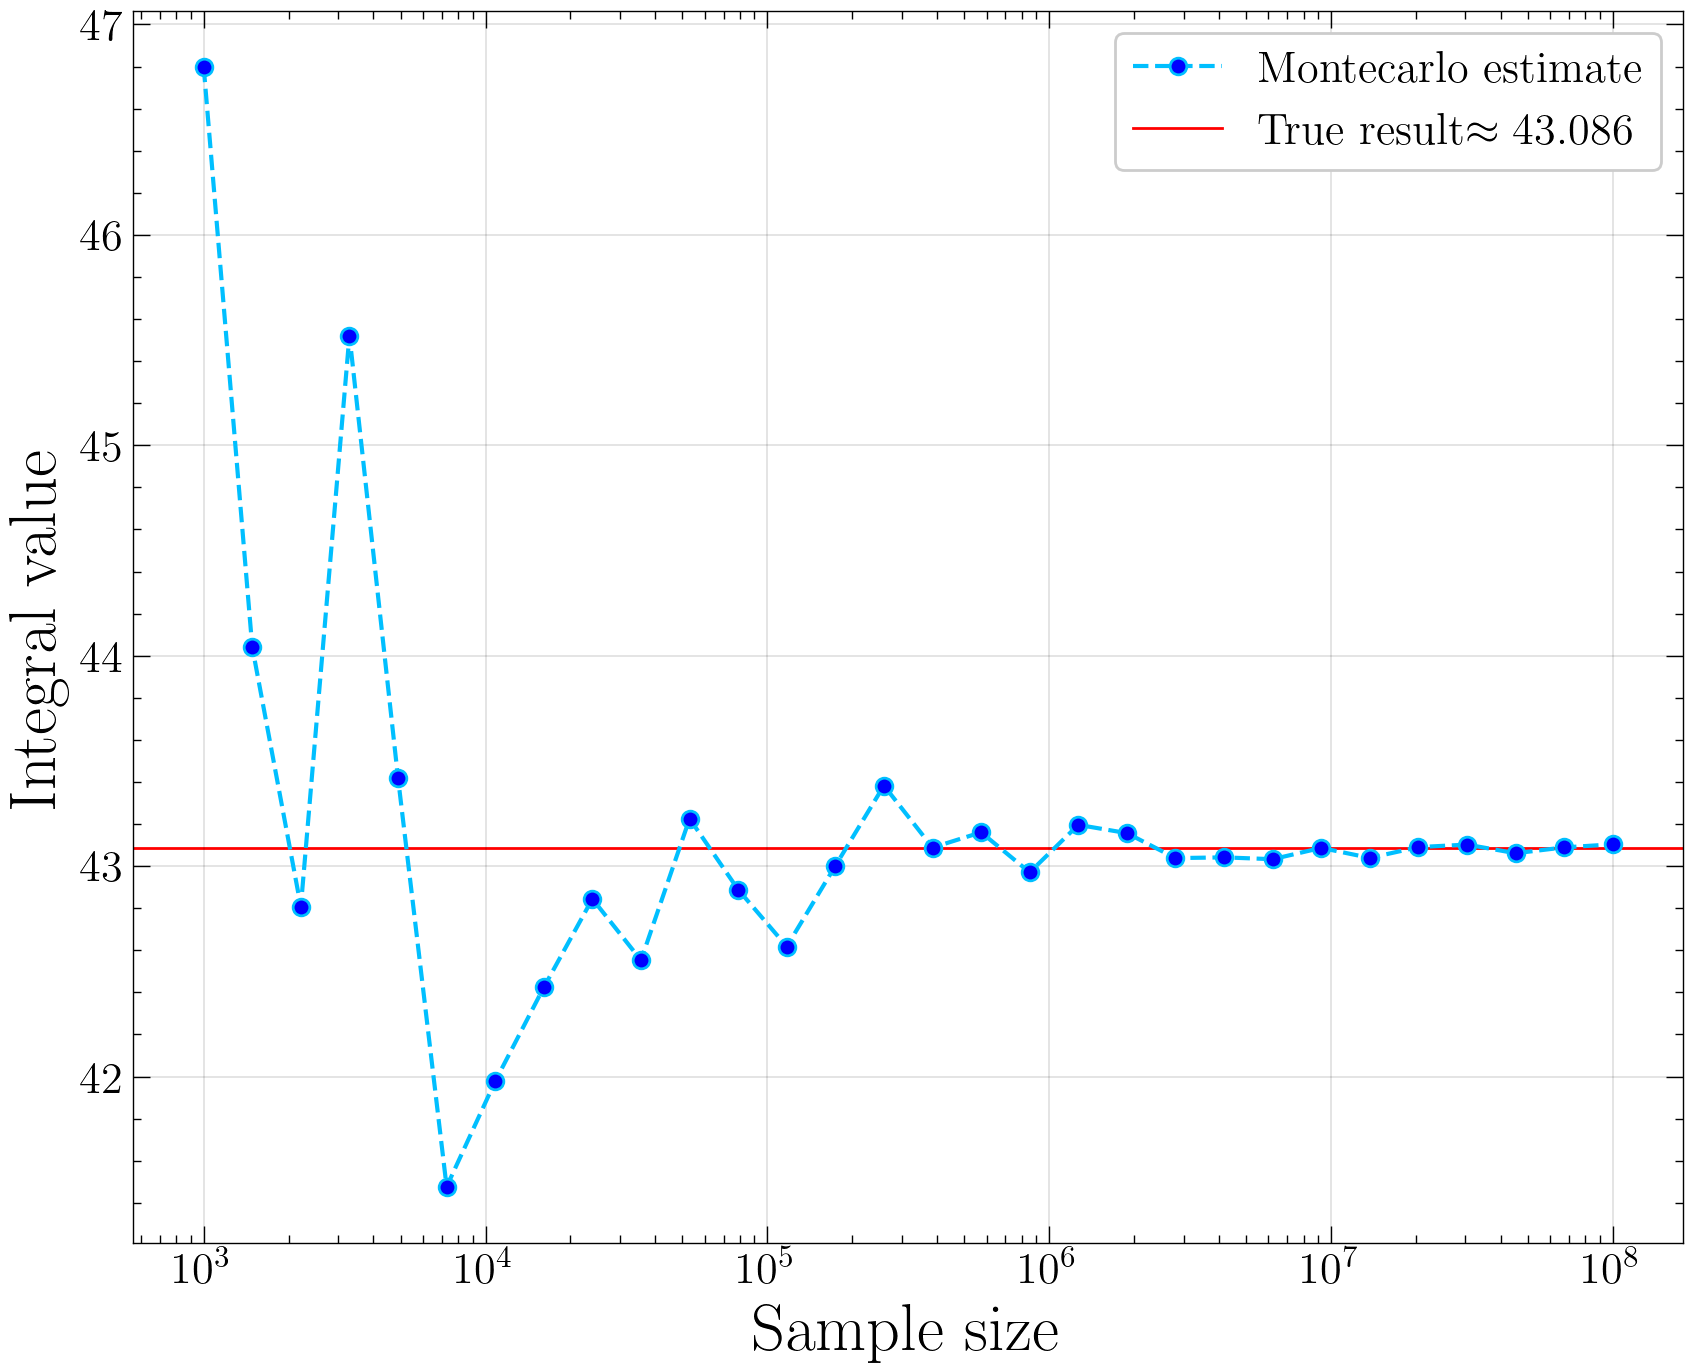

In [7]:
plt.plot(N_array, results, linestyle='--', color='deepskyblue', marker='o', markerfacecolor='blue', label='Montecarlo estimate')
plt.axhline(y=true_result, c='red', lw=1, label=f'True result$\\approx{true_result:.3f}$', zorder=0)
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('Integral value')
plt.legend();

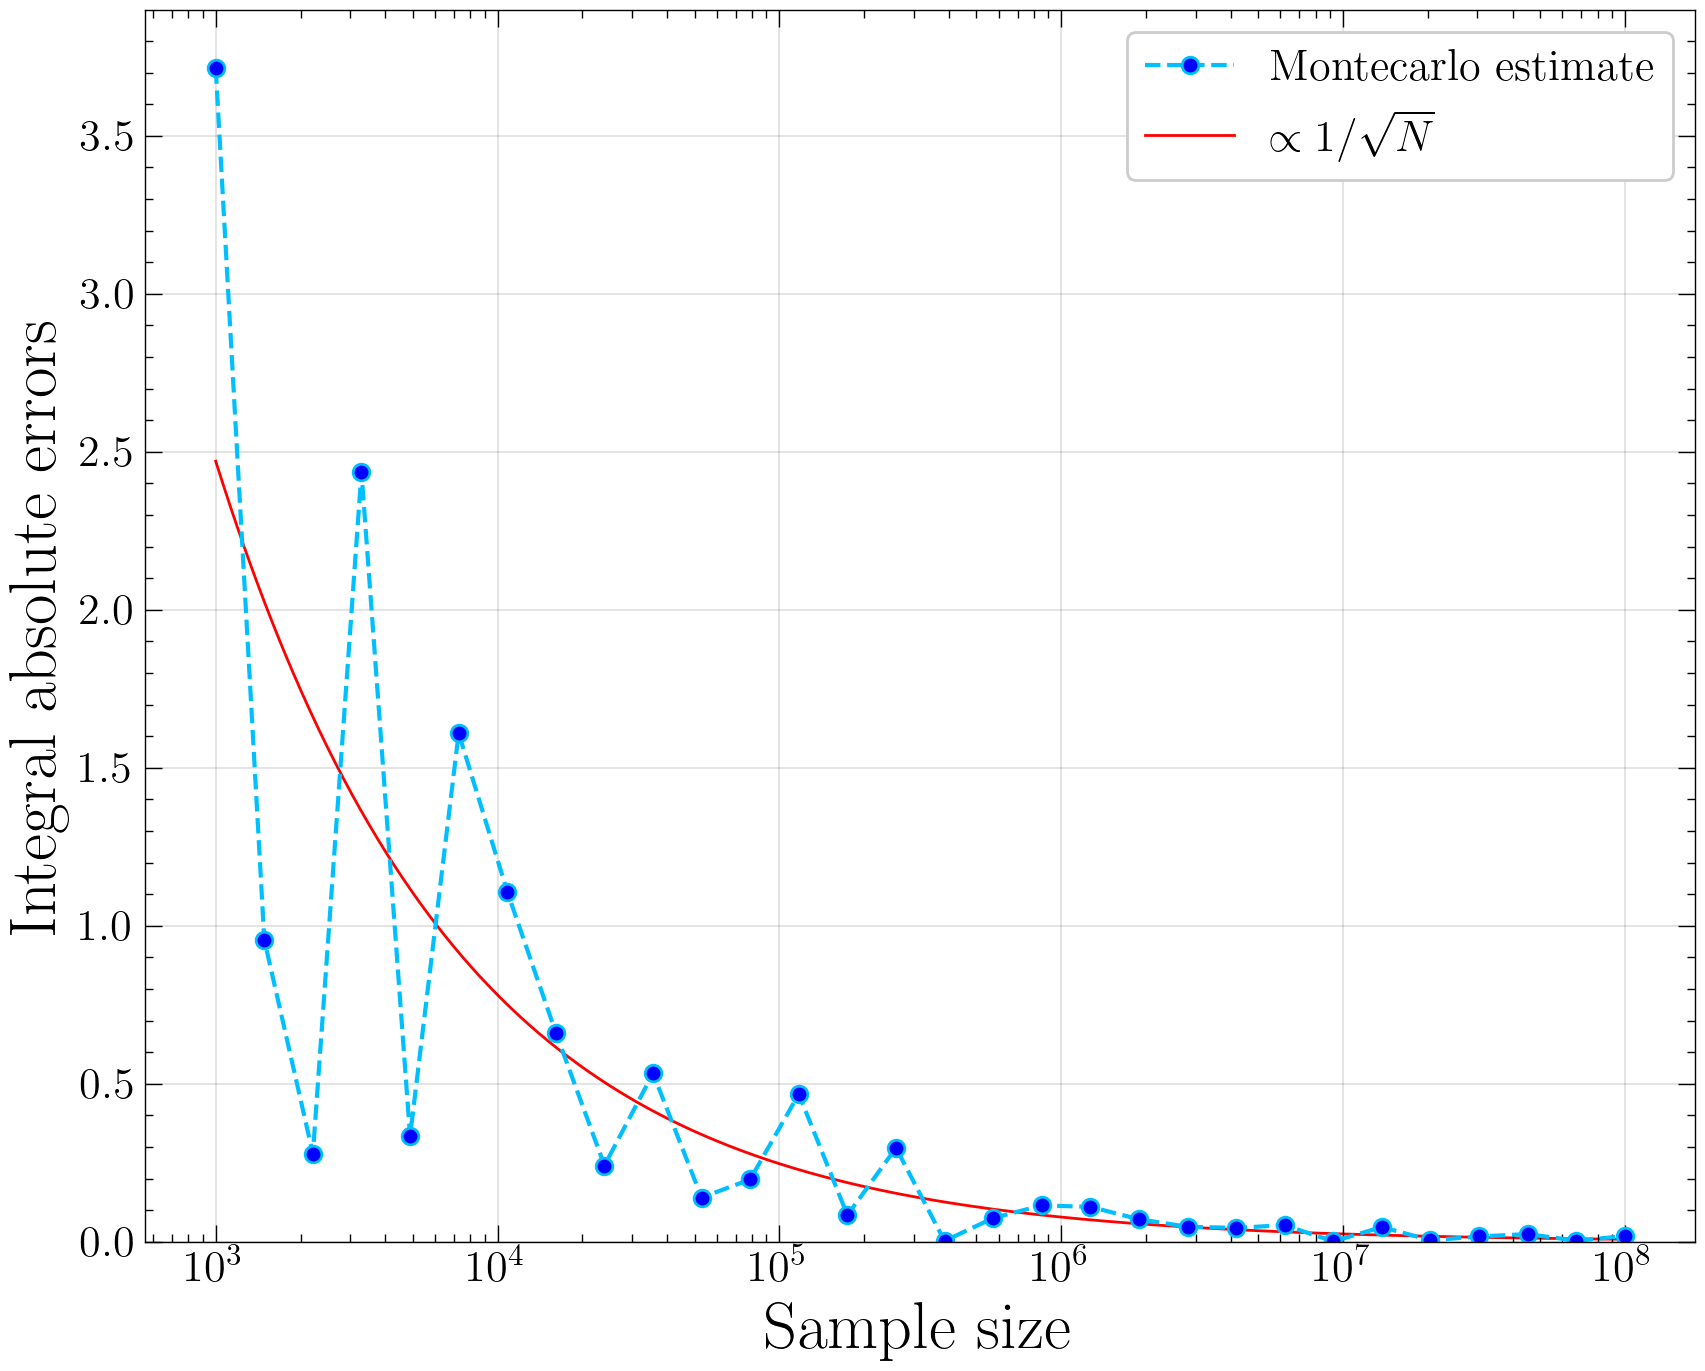

In [8]:
plt.plot(N_array, errors, linestyle='--', color='deepskyblue', marker='o', markerfacecolor='blue', label='Montecarlo estimate')
plt.ylim(0)
plt.xscale('log')
plt.xlabel('Sample size')
plt.ylabel('Integral absolute errors')

fit_result = curve_fit(lambda x, C: C*x**(-0.5), N_array, errors, [100])
x_dense = np.logspace(np.log10(np.min(N_array)), np.log10(np.max(N_array)), 1000)
plt.plot(x_dense, fit_result[0]*x_dense**(-0.5), c='red', lw=1, zorder=0, label='$\propto 1/\sqrt{N}$')
plt.legend();

## 2) Error Distribution

Given the sample size N, we will repeat the integration M times.

In [9]:
M = int(1e4)

In [10]:
def MontecarloDistribution(N, M, func, true_result, x_text, y_text):
    results = np.zeros(M)
    number_of_bins = 12
    
    # Evaluate the integral M times
    for i in tqdm(range(M)): 
        results[i] = GaussMontecarlo(N, func)
        
    # Plot the histogram of the results    
    plt.hist(results, density=True, bins=number_of_bins, color='lightblue', edgecolor='royalblue', alpha=0.7, label='Data', zorder=0)
    
    # Save the bins and the pdf-value of each bin
    y_fit, bins = np.histogram(results, density=True, bins=number_of_bins)
    x_fit = bins[:-1] + np.diff(bins)/2
    
    # Fit the histogram with a gaussian
    fit_result = curve_fit(stats.norm.pdf, x_fit, y_fit, [true_result, 1])
    mu = np.array([fit_result[0][0], np.sqrt(np.diag(fit_result[1]))[0]])
    sigma = np.array([fit_result[0][1], np.sqrt(np.diag(fit_result[1]))[1]])
    
    plt.plot(x_fit, stats.norm.pdf(x_fit, loc=fit_result[0][0], scale=fit_result[0][1]), marker='D', linestyle='--', c='lightseagreen', label='Model', zorder=2)
    plt.axvline(mu[0], c='red', lw=1, label='Mean', zorder=1)
    plt.axvline(true_result, c='black', ls='--', lw=1, label='True Value', zorder=1)
    
    plt.xlabel('Montecarlo estimate')
    plt.ylabel('pdf')
    plt.legend()
    
    # Text box
    textstr = '\n'.join((
        r'$\mu = %.3f \pm %.3f$' %(mu[0], mu[1]),
        r'$\sigma = %.3f \pm %.3f$' %(sigma[0], sigma[1])))

    plt.text(x_text, y_text, textstr, transform = plt.gca().transAxes, fontsize=14, bbox=dict(boxstyle="round4,pad=0.8", facecolor='lightblue', alpha=0.5, lw=1, edgecolor='royalblue'))
    
    return mu, sigma

### 2.1) Small N

100%|██████████| 10000/10000 [00:03<00:00, 2575.21it/s]


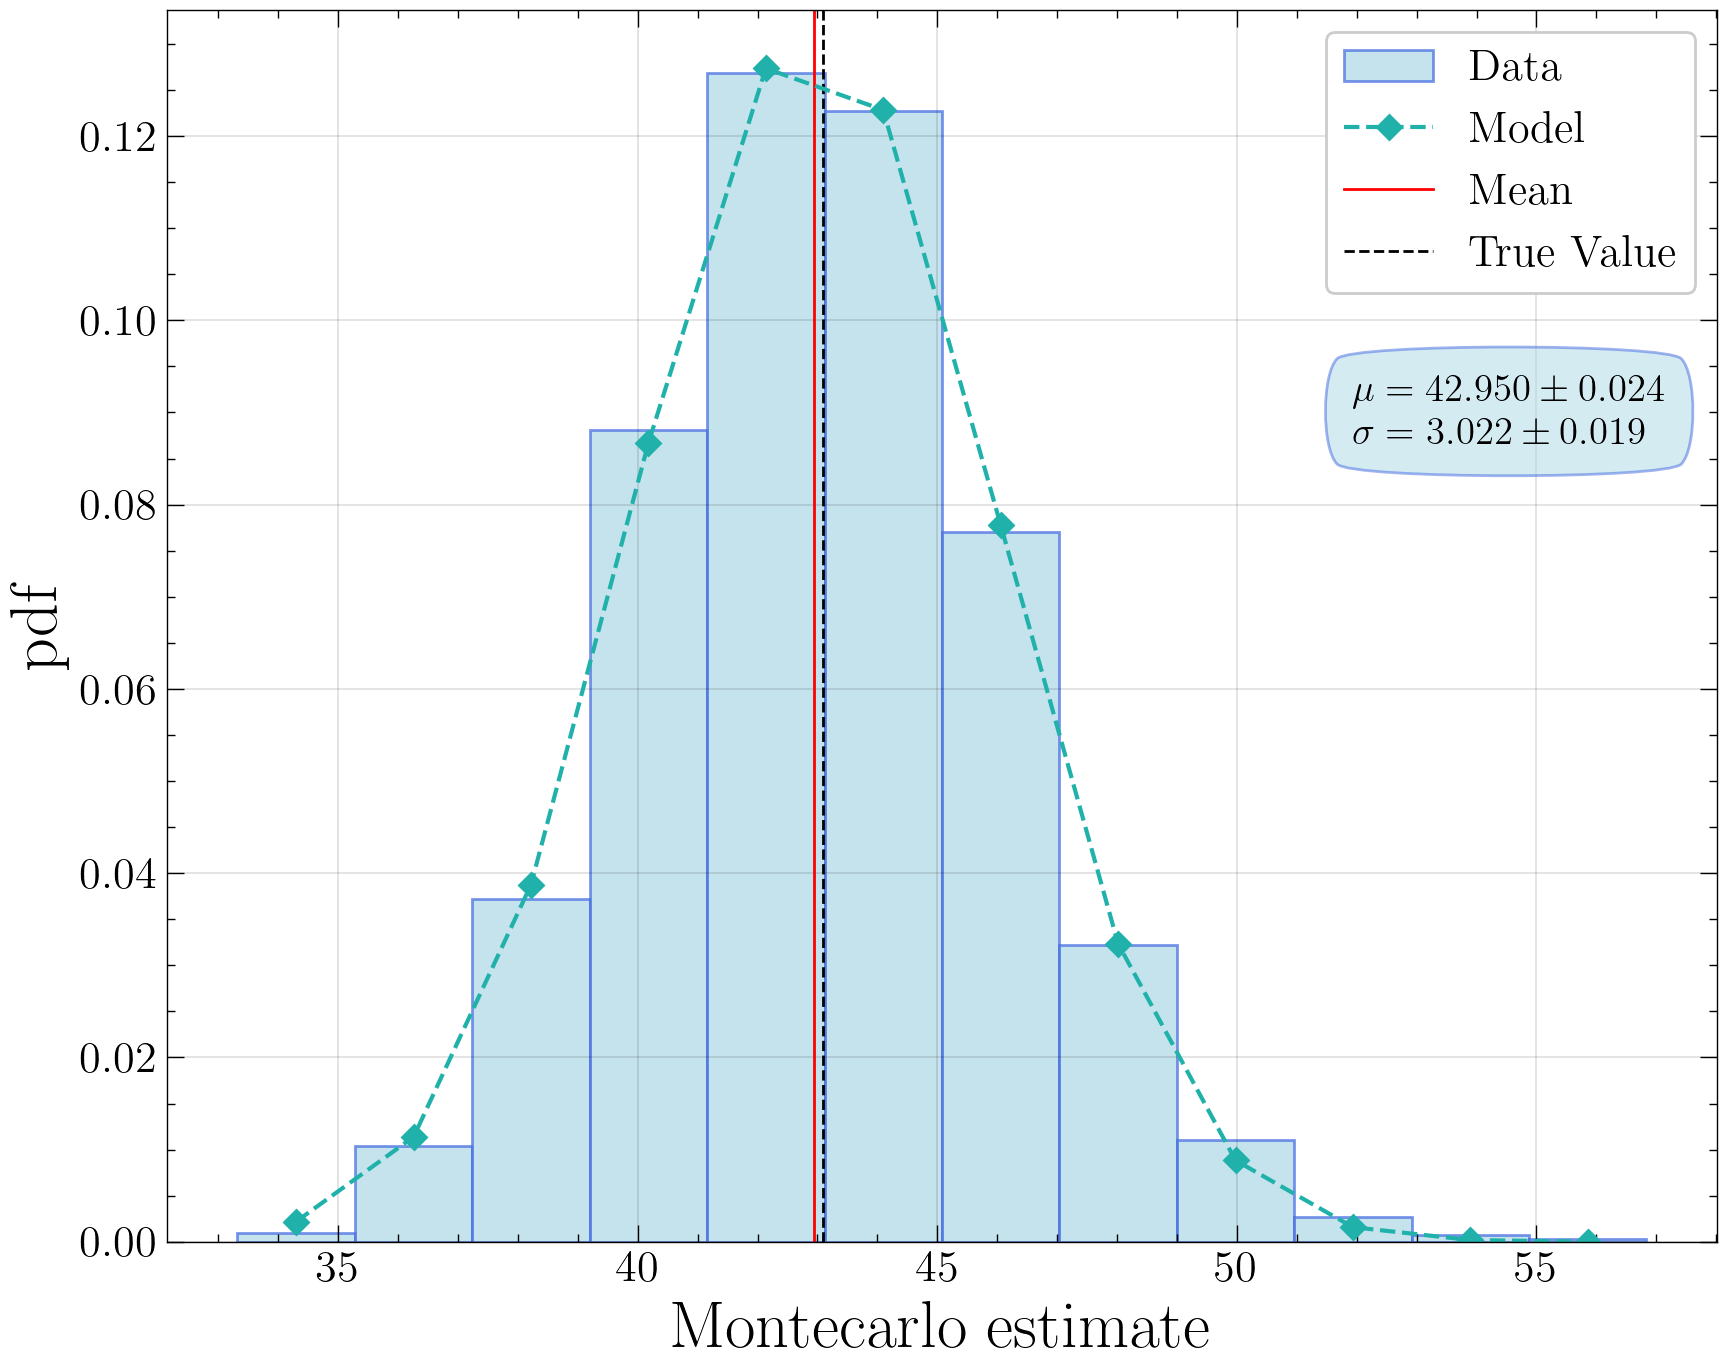

In [11]:
smallN = int(1e3)

smallN_results = MontecarloDistribution(smallN, M, f, true_result, 0.765, 0.65)

### 2.2) Big N

100%|██████████| 10000/10000 [00:35<00:00, 284.66it/s]


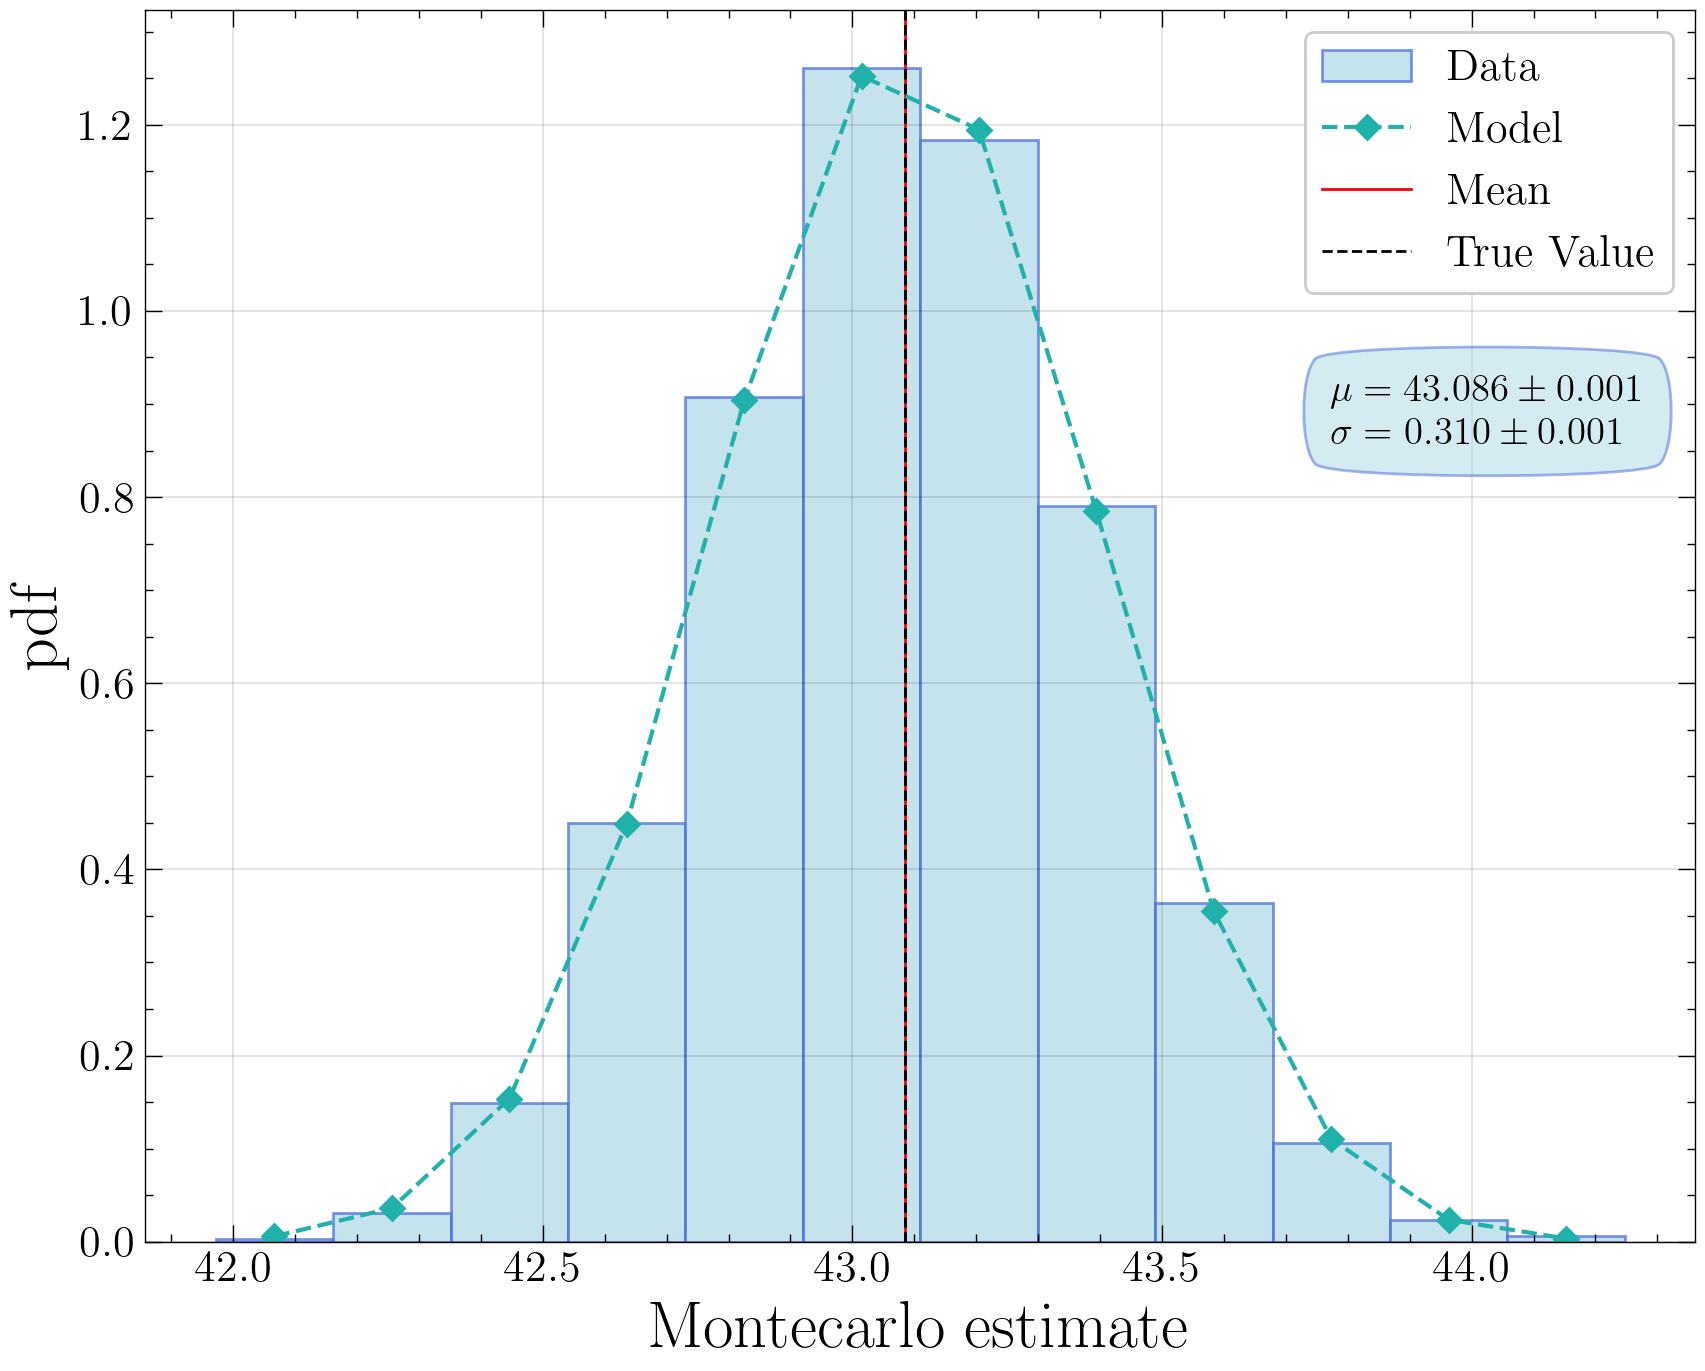

In [12]:
bigN = int(1e5)

bigN_results = MontecarloDistribution(bigN, M, f, true_result, 0.765, 0.65)

As expected, by increasing the sample size by a factor of $100$, the standard deviation of the gaussian errors decreases by a factor of $\sqrt{100}=10$.